In [1]:

import sys
root = '/home/emastr/github/phd/projects/vahid_project/'
sys.path.append('..')
sys.path.append(f'{root}src/')
sys.path.append(f'{root}util/')
sys.path.append(f'{root}data/')
from multiprocessing import Pool
from matplotlib.colors import LogNorm
from alignment_vmap import *
import numpy as np
from numpy.fft import fft, ifft

import jax
import time
from jax import vmap, grad, jit, random, lax
from jax import numpy as jnp
from jax.numpy.fft import fft as jfft, ifft as jifft
from util.logger import EventTracker
import matplotlib.pyplot as plt
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft, hessian_declarative, hessian_declarative_real
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion, manifold_iter
from itertools import product

In [2]:
def get_signal(L):
    t = jnp.linspace(0, 2*np.pi, L+1)[:-1]
    #x = (t < np.pi).astype(float)
    x = 0 * t
    x = x.at[0].set(1.)
    x = x - 1/5
    #x = jnp.exp(jnp.sin(t))
    return t, x

def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift


def create_signal(angle1, angle2, mean, xfft_abs):
    e1 = jnp.exp(1j * angle1)
    e2 = jnp.exp(1j * angle2)
    return jnp.array([mean,
                      e1 * xfft_abs[1],
                      e2 * xfft_abs[2],
                      e2.conj() * xfft_abs[3],
                      e1.conj() * xfft_abs[4]])
    
def hessian(z, yfft, y):
    y_align = vmap(align, (None, 0, 0))(z, yfft, y)
    return jnp.einsum('mi,mj -> ij', y_align, y_align) / y_align.shape[0]


def hessian_project(z, yfft, y):
    hes_ = hessian(z, yfft, y)
    hes_ = jfft(jfft(hes_, axis=0), axis=1)
    P = jnp.eye(len(z)) - jnp.outer(z, z.conj())/jnp.dot(z.conj(), z)
    return P @ hes_ @ P


def laplace(L):
    return jnp.roll(L, 1, axis=0) + jnp.roll(L, -1, axis=0) + jnp.roll(L, 1, axis=1) + jnp.roll(L, -1, axis=1) - 4*L


def get_angles(signal):
    fft_sig = jfft(signal)
    return jnp.angle(fft_sig[4]), jnp.angle(fft_sig[3])


MAXITER=100
def em_run(x0, y, noise_std):
    
    xlist = [jfft(x0)]    
    def callback(xfft, *args):
        xlist.append(xfft)
    em_method(jfft(x0), y, noise_std, tol=1e-6, batch_niter=3000, full_niter=MAXITER, callback=callback)
    return  xlist

def fpi_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means

    xlist = [jfft(x0)]    
    def callback(xfft, *args):
        xlist.append(xfft)
    
    fix_point_iter(jfft(x0), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-6, maxiter=MAXITER, callback=callback)
    return xlist

def man_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means

    xlist = [jfft(x0)]    
    def callback(xfft, *args):
        xlist.append(xfft)
    
    manifold_iter(jfft(x0), yfft, y_auto_fft, y_mean, alpha=2., tol=1e-6, maxiter=MAXITER, callback=callback)
    return xlist

def qp_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    
    xlist = [jfft(x0)]    
    def callback(xfft, *args):
        xlist.append(xfft)
            
    #approx_newton_declarative(jfft(x0), yfft, y_auto_fft, y_mean, step_size=0.9, tol=1e-10, maxiter=MAXITER, callback=callback)
    #print(x)
    approx_newton_declarative_real(jfft(x0), yfft, y, y_auto_fft, y_mean, step_size=0.9, tol=1e-10, maxiter=MAXITER, callback=callback)
    return xlist

def bsi_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_mean, yc_auto_fft, B = invariants_from_data(y, noise_std)
    
    xlist = [jfft(x0)]    
    def callback(z, *args):
        xfft = (yc_auto_fft ** 0.5) * z
        xfft = xfft.at[0].set(y_mean * L)
        
        # Hotfix
        xfft2 = (yc_auto_fft ** 0.5) * (-z)
        xfft2 = xfft2.at[0].set(y_mean * L)

        x = ifft(xfft).real
        x2 = ifft(xfft2).real
        if loss_fft(jfft(x), yfft) > loss_fft(jfft(x2), yfft):
            x = x2  
        xlist.append(jfft(x))
    
    bispectrum_inversion(y_mean, yc_auto_fft, B, tol=1e-6, maxiter=(200, MAXITER), callback=callback)
    return xlist


N = int(1e3)
n_pix = 200
L = 5
stdev = 0.3

t, x = get_signal(L)
y, noise, shift = get_samples(random.PRNGKey(4), x, stdev, N)
xfft = jfft(x)

yfft = jfft(y, axis=1)
ymean, yauto_fft, _ = invariants_from_data(y, stdev)
yabs_fft = yauto_fft**0.5

methods = [em_run, fpi_run, bsi_run, qp_run, man_run]
names = ['EM', 'FPI', 'BSI', 'Hess', 'Man']
marker = ['o', '^', 's', 'v', 'x']
colors = ['r', 'orange', 'b', 'c', 'm']
method_data = []
x0 = random.normal(random.PRNGKey(0), (L,))*1.#y[2] + 
converged = []
for i, method in enumerate(methods):
    xmfft = jnp.array(method(x0, y, stdev))
    xmfft = [align_fft(xfft, xmi) for xmi in xmfft]
    #error = [jnp.linalg.norm(xmi - fft(x)) for xmi in xmfft]
    #plt.plot([loss_fft(xmi, yfft) for xmi in xmfft], label=names[i])
    #plt.plot(error, label=names[i])
    t1_m, t2_m = vmap(get_angles)(ifft(xmfft))
    method_data.append((t1_m % (2*np.pi), t2_m % (2*np.pi)))
    converged.append(ifft(xmfft[-1]))
#plt.legend()

def loss_fft_angle(angle1, angle2):
    z = create_signal(angle1, angle2, ymean, yabs_fft)
    return loss_fft(z, yfft)

loss_ = jit(vmap(vmap(loss_fft_angle, (0, 0)), (0,0)))
loss_2 = jit(vmap(loss_fft_angle, (0, 0)))

t1x , t2x = get_angles(x)
t1x = t1x % (2*np.pi)
t2x = t2x % (2*np.pi)

t1_y, t2_y = vmap(get_angles, (0))(y)
t1_y, t2_y = t1_y % (2*np.pi), t2_y % (2*np.pi)

T1, T2 = np.meshgrid(np.linspace(0, 2*np.pi, n_pix), np.linspace(0, 2*np.pi, n_pix))
#L12 = loss_(T1, T2)
L12 = np.zeros_like(T1)
for i in range(n_pix):
    L12[i, :] = loss_2(T1[i], T2[i])
    #for j in range(n_pix):
        #L12[i, j] = loss_fft_angle(T1[i, j], T2[i, j])
    print(i, end='\r')


I0000 00:00:1711647818.804807   12692 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FPI 6
FPI 6
Man 101


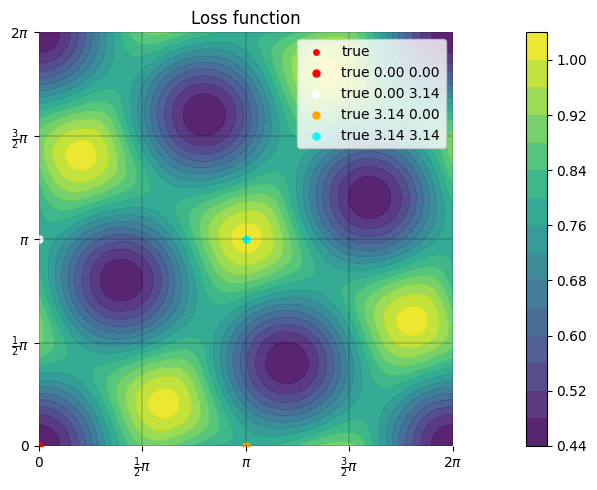

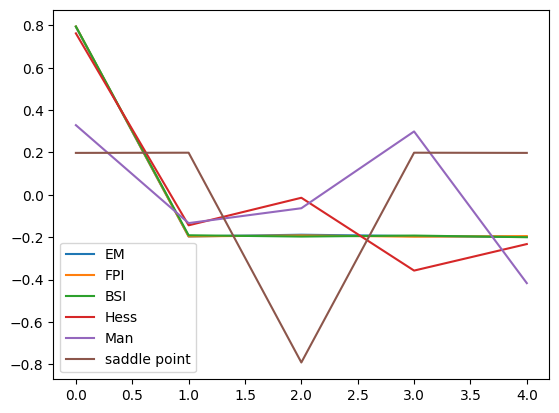

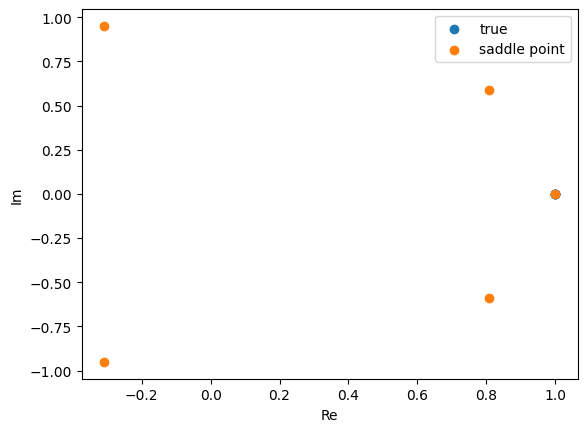

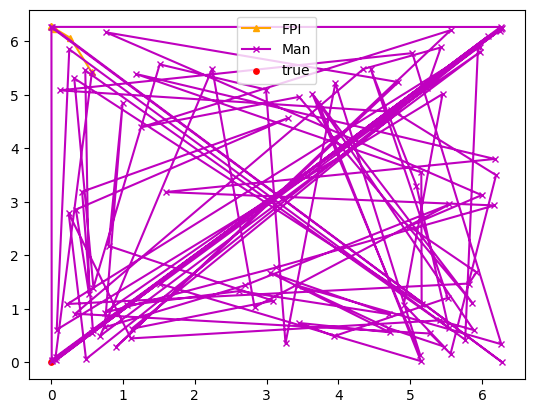

In [3]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(111, aspect=1/jnp.abs(xfft[1]/xfft[2]))
#fig.add_subplot(111, aspect=1.)
plt.title("Loss function")
#plt.pcolormesh(T1[:-1,:-1], T2[:-1, :-1], laplace(L12[:-1, :-1]))
#plt.contourf(T1[:-1,:-1], T2[:-1, :-1], laplace(L12[:-1, :-1]), cmap="magma")
#plt.pcolormesh(T1, T2, L12, cmap="Greys")#, alpha=0.8)
plt.contourf(T1, T2, L12, cmap="viridis", alpha=0.9, levels=17)
plt.colorbar()
for i, (data, name, color) in enumerate(zip(method_data, names, colors)):
    if name in ["FPI"]:
    #if name in ["FPI", "Man"]:
        print(name, len(data[0]))
        #plt.plot(data[0], data[1], label=name, marker=marker[i], color=colors[i], markersize=4)
        #plt.scatter(data[0], data[1], label=name, s=8, marker=marker[i])
plt.scatter(t1x, t2x, color="red", s=15, label="true")



colors_ab = ["red", "orange", "white", "cyan"]
for i, a in enumerate([0, np.pi]):
    for j, b in enumerate([0, np.pi]):
        plt.scatter(a, b, color=colors_ab[i+2*j], s=25, label=f"true {a:.2f} {b:.2f}")


plt.legend()
#plt.axis("equal")
plt.xlim([0, 2*np.pi])
plt.ylim([0, 2*np.pi])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(color="black", linewidth=0.2)
labels = ["$0$", "$\\frac{1}{2}\pi$", "$\pi$", "$\\frac{3}{2}\pi$", "$2\pi$"]
#plt.scatter(t1_y, t2_y, color="black", s=1)
plt.xticks([r*np.pi/2 for r in range(5)], labels)
plt.yticks([r*np.pi/2 for r in range(5)], labels)
plt.tight_layout()


fig.savefig(f"{root}/data/loss_function.pdf")
fig.savefig(f"/home/emastr/Downloads/heatmap.png")

c = 0.8
t1x2, t2x2 = t1x+jnp.pi*c/4, t2x-jnp.pi*c*1.5/2
plt.figure()
xsaddlefft = create_signal(t1x2, t2x2, ymean, yabs_fft)
xsaddle = ifft(xsaddlefft).real
for method, data in zip(names, converged):
    plt.plot(data.real, label=method)
plt.plot(xsaddle.real, label="saddle point")
plt.legend()


plt.figure()
z = xfft/np.abs(xfft)
z2 = xsaddlefft/np.abs(xsaddlefft)
plt.scatter(z.real, z.imag, label="true")
plt.scatter(z2.real, z2.imag, label="saddle point")
plt.xlabel("Re")
plt.ylabel("Im")
plt.legend()

plt.figure()
for i, (data, name, color) in enumerate(zip(method_data, names, colors)):
    if name in ["FPI", "Man"]:
        print(name, len(data[0]))
        plt.plot(data[0], data[1], label=name, marker=marker[i], color=color, markersize=4)
        #plt.scatter(data[0], data[1], label=name, s=8, marker=marker[i])
plt.scatter(t1x, t2x, color="red", s=15, label="true")
plt.legend()
